<a href="https://colab.research.google.com/github/Kaunaz/Assets/blob/master/notebooks/ResUnetV3_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import random
import gdown
import shutil
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import plotly.graph_objs as go
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2
from torchvision import models
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from collections import OrderedDict
import math

try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from timm.models.layers import trunc_normal_, DropPath
    from timm.models.registry import register_model
except:
    !pip install -q timm
    from timm.models.layers import trunc_normal_, DropPath
    from timm.models.registry import register_model

datasets_info = {
    's':{
        'filename': 'small_dataset',
        'download_id': '1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF',
    },
    'm':{
        'filename': 'medium_dataset',
        'download_id': '1p06JpS-34-_4Ra5qmC19HWRxkHgctLjP'
    }
    # 'l':{ # TODO
}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.1 MB/s eta 0:00:00


In [ ]:
DATASET='s' # 's' for small, 'm' for medium, 'l' for large
MODEL_NAME = 'ResUnetV3-3Conv-3Skip' # CHANGE NAME

CHECKPOINT_STEP = 1
BATCH_SIZE = 16
MODELS_PATH = 'models'
RANDOM_SEED = 1

DEBUG = False

DATASET_INFO = datasets_info[DATASET]
DATASET_PATH = DATASET_INFO['filename'] # 'dataset' in VM
Path(MODELS_PATH).mkdir(parents=True, exist_ok=True)

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


PROCESSES = 16
WORKERS = os.cpu_count()


random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)


if DEBUG:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Setup

## Dataset

### Download Dataset

In [ ]:
# Check if dataset is already downloaded
if not os.path.exists(f'{DATASET_PATH}.tar.gz'):

    url = f'https://drive.google.com/uc?id={DATASET_INFO["download_id"]}'

    gdown.download(url, quiet=False)

    !tar -xf {DATASET_PATH}.tar.gz # CHANGE NAME
else:
    print(f'{DATASET_PATH}.tar.gz already downloaded')

Downloading...
From (original): https://drive.google.com/uc?id=1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF
From (redirected): https://drive.google.com/uc?id=1Fiqy5bkIp1HD8NKjiQaME-2QSFzO7lDF&confirm=t&uuid=e309b8ee-b52a-4886-bde6-18d4de091f69
To: /content/small_dataset.tar.gz
100%|██████████| 798M/798M [00:07<00:00, 114MB/s]


### Dataset Utils

In [ ]:
def filenames_per_map(folder, idx):
    idx_str = f"{idx:05d}"
    filenames = []

    for filename in os.listdir(folder):
        primera_parte, _ = filename.split('_')
        if primera_parte == idx_str:
            filenames.append(filename)

    return filenames


def maps(folder):
    filenames = os.listdir(folder)
    number_maps = [filename.split('_')[0] for filename in filenames]
    number_maps = map(int, number_maps)
    number_maps = sorted(list(set(number_maps)))
    return number_maps


def calculate_outliers(path, tol=2):
    image = np.load(path)

    max_val = np.max(image)
    min_val = np.min(image)

    if abs(min_val) > 2 or abs(max_val) > 2:
        return path


def calculate_outliers_dataset(folder_path, tol=2, filesave=False):
    os.listdir(folder_path)
    with Pool(PROCESSES) as pool:
        results = pool.starmap(calculate_outliers, [(os.path.join(folder_path, filename), tol) for filename in os.listdir(folder_path)])
    results =  [os.path.basename(result) for result in results if result is not None]

    if filesave:
        with open('outliers.txt', 'w') as f:
            for item in results:
                f.write("%s\n" % item)

    return results


def calculate_max_min(path):
    image = np.load(path)

    max_val = np.max(image)
    min_val = np.min(image)

    return np.array([max_val, min_val])


def calculate_max_min_dataset(folder_path, exclude_filename=None):
    if exclude_filename is not None:
        with open(exclude_filename, 'r') as f:
            exclude_filenames = f.read().splitlines()
    else:
        exclude_filenames = []

    filenames = [filename for filename in os.listdir(folder_path) if filename not in exclude_filenames]

    with Pool(PROCESSES) as pool:
        results = pool.map(calculate_max_min, [os.path.join(folder_path, filename) for filename in filenames])
    results = np.array(results)

    min_epsilon = results.min(axis=0)[1]
    max_epsilon = results.max(axis=0)[0]

    return min_epsilon, max_epsilon


def calculate_mean_std_image(path, channels=3):
    sum_means = np.zeros(channels)
    sum_stds = np.zeros(channels)

    image = np.load(path)
    mean_per_channel = np.mean(image, axis=(1, 2))
    std_per_channel = np.std(image, axis=(1, 2))

    sum_means += mean_per_channel
    sum_stds += std_per_channel


    return np.array([sum_means, sum_stds])


def calculate_mean_std_dataset(folder_path, channels=3):
    with Pool(PROCESSES) as pool:
        results = pool.starmap(calculate_mean_std_image, [(os.path.join(folder_path, filename), channels) for filename in os.listdir(folder_path)])
    results = np.array(results)
    results = np.mean(results, axis=0)
    return results

In [ ]:
# mean_std = calculate_mean_std_dataset(os.path.join(DATASET_PATH, 'EPSILON'))
# min_max = calculate_max_min_dataset(os.path.join(DATASET_PATH, 'EPSILON'))

In [ ]:
# dataset_means, dataset_stds = mean_std[0], mean_std[1]
# dataset_min, dataset_max = min_max

### Dataset Class

In [ ]:
class LensingDataset(Dataset):
    def __init__(self, root_dir, transform=None, transform_test=None):
        self.root_dir = root_dir
        self.transform = transform
        self.epsilon_dir = os.path.join(root_dir, 'EPSILON')
        self.kappa_dir = os.path.join(root_dir, 'KAPPA')

        self.epsilon_files = os.listdir(self.epsilon_dir)
        self.kappa_files = os.listdir(self.kappa_dir)

        self.epsilon_files.sort()
        self.kappa_files.sort()

    def __len__(self):
        return len(self.epsilon_files)


    def __getitem__(self, idx):
        epsilon_image_path = os.path.join(self.epsilon_dir, self.epsilon_files[idx])
        kappa_image_path = os.path.join(self.kappa_dir, self.kappa_files[idx])

        epsilon_image = np.load(epsilon_image_path)
        kappa_image = np.load(kappa_image_path)

        kappa_image = np.expand_dims(kappa_image, axis=0)

        epsilon_image = torch.from_numpy(epsilon_image).float()
        kappa_image = torch.from_numpy(kappa_image).float()

        if self.transform:
            epsilon_image = self.transform(epsilon_image)

        return epsilon_image, kappa_image

In [ ]:
class BaselineAugmentation(object):
    def __init__(self):
        self.rotations = [0, 90, 180, 270]

    def __call__(self, x):
        angle = random.choice(self.rotations)
        x = v2.functional.rotate(x, angle)

        if random.random() > 0.5:
            x = v2.functional.hflip(x)
        if random.random() > 0.5:
            x = v2.functional.vflip(x)
        return x


class ToTensor(object):
    def __init__(self):
        pass

    def __call__(self, x):
        return torch.from_numpy(x).float()


class ReParameterize(object):
    def __init__(self):
        pass

    def __call__(self, epsilon):
        epsilon1 = epsilon[0, :, :]
        epsilon2 = epsilon[1, :, :]
        delta_epsilon = epsilon[2, :, :]

        magnitude_torch = torch.sqrt(epsilon1**2 + epsilon2**2)
        angle_torch = torch.atan2(epsilon2, epsilon1)

        reconstructed_epsilon = torch.stack([epsilon1, epsilon2, delta_epsilon, magnitude_torch, angle_torch], dim=0)
        return reconstructed_epsilon


class PreProcessing(object):
    def __call__(self, reconstructed_epsilon):
        magn = reconstructed_epsilon[3]

        magn = (magn - magn.min()) / (magn.max() - magn.min())

        hist = torch.histc(magn, bins=256, min=0, max=1)
        cdf = hist.cumsum(0)
        cdf = (cdf - cdf.min()) / (cdf.max() - cdf.min())
        magn = cdf[(magn * 255).long()] / 255.0

        magn = self.median_filter(magn, kernel_size=9)

        angle = self.median_filter(reconstructed_epsilon[4], kernel_size=7)

        magn_angle = torch.stack([magn, angle], dim=0)
        return torch.cat([reconstructed_epsilon[:3], magn_angle], dim=0)

    def median_filter(self, input_tensor, kernel_size):
        if input_tensor.dim() == 2:
            input_tensor = input_tensor.unsqueeze(0)

        padding = kernel_size // 2
        input_padded = F.pad(input_tensor, (padding, padding, padding, padding), mode='reflect')

        unfolded = input_padded.unfold(1, kernel_size, 1).unfold(2, kernel_size, 1)
        unfolded = unfolded.contiguous().view(unfolded.size(1), unfolded.size(2), -1)

        median_filtered = unfolded.median(dim=-1)[0]

        return median_filtered.squeeze(0)


# In the case of min-max normalization values must be (min, max),
# TODO: implement normalization per channel
# And in the case of standarization values must be (mean, std) where mean and
# std are arrays
class Normalize(object):
    def __init__(self, method='min_max', values=(-2,2)):
        self.method = method
        self.values = values

    def __call__(self, x):
        if self.method == 'min_max':
            min_value, max_value = self.values
            x = (x - min_value) / (max_value - min_value)
            return x
        elif self.method == 'standarization':
            mean, std = self.values
            x = v2.Normalize(mean=mean, std=std)(x)
            return x

### Dataset Loader

In [ ]:
transform = v2.Compose([
    # Normalize(method='min_max', values=(dataset_min, dataset_max)),
    # Normalize(method='standarization', values=(dataset_means, dataset_stds)),
    ReParameterize(),
])

VM_TRAINING = False

lensing_dataset = LensingDataset(root_dir=DATASET_PATH, transform=None)

if VM_TRAINING:
    train_set, val_set = random_split(lensing_dataset, [0.80, 0.20]) # VM TRAINING
    train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          generator=torch.Generator().manual_seed(RANDOM_SEED), num_workers=WORKERS)
    val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
else:
    train_set, val_set, test_set = random_split(lensing_dataset, [0.75, 0.2, 0.05])
    train_loader = DataLoader(dataset=train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          generator=torch.Generator().manual_seed(RANDOM_SEED), num_workers=WORKERS)
    val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
    test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=False, num_workers=WORKERS)

In [ ]:
train_loader.__len__(), val_loader.__len__(), test_loader.__len__() if test_loader else None

(349, 93, 371)

### Visualization

In [ ]:
def plot_record(epsilon, kappa, show_axis=False, cmap=None):
    if show_axis:
        axis = 'on'
    else:
        axis = 'off'

    epsilon_vmin = np.min(epsilon)
    epsilon_vmax = np.max(epsilon)

    kappa_vmin = np.min(kappa)
    kappa_vmax = np.max(kappa)

    plt.figure(figsize=(12, 7))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.subplot(1, 4, 1)
    plt.imshow(epsilon[0], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Epsilon 1')
    plt.axis(axis)

    plt.subplot(1, 4, 2)
    plt.imshow(epsilon[1], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Epsilon 2')
    plt.axis(axis)

    plt.subplot(1, 4, 3)
    plt.imshow(epsilon[2], vmin=epsilon_vmin, vmax=epsilon_vmax, cmap=cmap)
    plt.title('Delta Epsilon')
    plt.axis(axis)

    plt.subplot(1, 4, 4)
    plt.imshow(kappa, vmin=kappa_vmin, vmax=kappa_vmax, cmap=cmap)
    plt.title('Kappa')
    plt.axis(axis)

    plt.show()


def plot_kappa(kappa_true, kappa_pred, show_axis=False, show_dpeaks=False, cmap=None):
    kt= kappa_true.astype(np.float32)
    kp= kappa_pred.astype(np.float32)
    if show_axis:
        axis = 'on'
        plt.figure(figsize=(7, 3))
    else:
        axis = 'off'
        plt.figure(figsize=(6, 3))

    if show_dpeaks:
        dpeaks_true = find_top_k_peaks(kt)
        dpeaks_pred = find_top_k_peaks(kp)
        dpeaks_true_x, dpeaks_true_y = dpeaks_true[:, 1], dpeaks_true[:, 0]
        dpeaks_pred_x, dpeaks_pred_y = dpeaks_pred[:, 1], dpeaks_pred[:, 0]

    plt.subplots_adjust(wspace=0.1, hspace=0.1)

    plt.subplot(1, 2, 1)
    plt.imshow(kt, cmap=cmap)
    plt.title('Kappa True')
    if show_dpeaks:
        plt.scatter(dpeaks_true_x, dpeaks_true_y, color='red')
        for i in range(len(dpeaks_true_y)):
            plt.text(dpeaks_true_x[i], dpeaks_true_y[i], str(i + 1), fontsize=12, ha='right', va='bottom', color='red')

    plt.axis(axis)

    plt.subplot(1, 2, 2)
    plt.imshow(kp, cmap=cmap)
    plt.title('Kappa Prediction')
    if show_dpeaks:
        plt.scatter(dpeaks_pred_x, dpeaks_pred_y, color='red')
        for i in range(len(dpeaks_true_y)):
            plt.text(dpeaks_pred_x[i], dpeaks_pred_y[i], str(i + 1), fontsize=12, ha='right', va='bottom', color='red')
    plt.axis(axis)

    plt.show()

def intensity_histogram(image, range=(-0.5, 0.5)):
    plt.hist(image.flatten(), bins=200, alpha=0.6, label='Pred', color='orange', range=range)
    plt.legend(loc='upper right')
    plt.title('Histograma de Epsilon')
    plt.xlabel('Epsilon Value')
    plt.ylabel('Frequency')
    plt.show()

## Metrics

In [ ]:
# WMAPE
def wmape_handcrafted(y_true : torch.Tensor, y_pred : torch.Tensor):
    W = 1 + (y_true / torch.max(y_true))

    y_true = torch.where(y_true == 0, torch.tensor(1e-7), y_true)
    randderecha = torch.abs(y_pred - y_true) / torch.abs(y_true)
    num = torch.sum(W * randderecha)

    denom = torch.sum(W)
    return (num / denom).item()

def wmape(T:torch.Tensor, P:torch.Tensor, delta = torch.tensor(1e-5)):
    T = torch.where(T == 0.0, delta, T)
    P = torch.where(P == 0.0, delta, P)
    W_fun = lambda T, max_T: 1 + (T/max_T)
    max_T = torch.max(T)
    W = W_fun(T, max_T)
    Numerator = W*(torch.abs(P-T)/torch.abs(T))
    sum_W = torch.sum(W)
    sum_Numerator = torch.sum(Numerator)
    return (sum_Numerator/sum_W).item()


# DICEE
def dicee_handcrafted(y_true: torch.Tensor, y_pred: torch.Tensor, alpha=0.5, beta=0.5):
    G = (y_true > torch.mean(y_true)).int()
    A = (y_pred > torch.mean(y_pred)).int()
    return (1 - torch.sum(G * A) / (torch.sum(G * A) + alpha * torch.sum((1 - G) * A) + beta * torch.sum((1 - A) * G))).item()

def DICE_binary_mask(Tensor:torch.tensor):
    Tensor_mask = Tensor - torch.mean(Tensor)
    Tensor_mask[torch.where(Tensor_mask > 0)] = 1
    Tensor_mask[torch.where(Tensor_mask <= 0)] = 0
    return Tensor_mask

def dicee(T:torch.Tensor, P:torch.Tensor, alpha:float = 0.5, beta:float = 0.5):
    if T.shape != P.shape: return None
    G = DICE_binary_mask(T)
    A = DICE_binary_mask(P)
    sum_G_A = torch.sum(G*A)
    sum_alpha = torch.sum(A*(1-G))
    sum_beta = torch.sum(G*(1-A))
    return (1-(sum_G_A/(sum_G_A + alpha*sum_alpha + beta*sum_beta))).item()


# DPEAKS
def find_top_k_peaks(im ,sigma=3, N=3):
    smoothed = gaussian_filter(im, sigma=sigma)
    coordinates = peak_local_max(smoothed,threshold_abs=None, num_peaks=N)
    while len(coordinates) < 3: coordinates = np.vstack([coordinates,np.array([0,0])])
    return coordinates

def official_dpeaks(T:np.ndarray, P:np.ndarray, num_peaks = 3):
    PEAKS_T = find_top_k_peaks(T, N=num_peaks)
    PEAKS_P = find_top_k_peaks(P, N=num_peaks)
    sum_DPEAKS = np.sum(np.abs(PEAKS_T-PEAKS_P))
    return sum_DPEAKS

def dpeaks(y_true : torch.Tensor, y_pred : torch.Tensor, num_peaks=3):
    y_true_np = y_true.cpu().numpy().astype(np.float32)
    y_pred_np = y_pred.cpu().numpy().astype(np.float32)

    dpeaks_sum = 0
    batch_size = y_true_np.shape[0]

    for i in range(batch_size):
        y_true_im = y_true_np[i].squeeze()
        y_pred_im = y_pred_np[i].squeeze()

        dpeaks_im = official_dpeaks(y_true_im, y_pred_im, num_peaks)
        dpeaks_sum += dpeaks_im

    return (dpeaks_sum / batch_size).item()

## Losses

In [ ]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, y_true, y_pred):
        max_val = torch.max(y_true)
        weights = 1 + (torch.abs(y_true) / max_val)

        loss = weights * (y_pred - y_true) ** 2
        return torch.sum(loss)

class CombinedLoss(nn.Module):
    def __init__(self, WMSE_w= 0.3, dicee_w= 0.3, WMAPE_w= 0.3, dpeaks_w= 0.1):
        super(CombinedLoss, self).__init__()
        self.WMSE_loss = WeightedMSELoss()
        self.WMSE_w =  WMSE_w
        self.dicee_w = dicee_w
        self.WMAPE_w = WMAPE_w
        self.dpeaks_w = dpeaks_w

    def forward(self, y_true, y_pred):
        y_true_detach = y_true.detach()
        y_pred_detach = y_pred.detach()

        WMSE_loss = self.WMSE_loss(y_pred, y_true)
        dicee_loss = dicee(y_true_detach, y_pred_detach)
        WMAPE_loss = wmape(y_true_detach, y_pred_detach)
        dpeaks_loss = dpeaks(y_true_detach, y_pred_detach)

        return (WMSE_loss*self.WMSE_w + dicee_loss*self.dicee_w + WMAPE_loss*self.WMAPE_w + dpeaks_loss*self.dpeaks_w)


class SSIM_Loss(nn.Module):
    def __init__(self, max_val=1.0, win_size=7):
        super(SSIM_Loss, self).__init__()
        self.max_val = max_val
        self.win_size = win_size

    def forward(self, pred, target):
        pred_min, pred_max = pred.min(), pred.max()
        target_min, target_max = target.min(), target.max()

        pred_range = pred_max - pred_min
        target_range = target_max - target_min

        pred_range = max(pred_range.item(), 1e-5)
        target_range = max(target_range.item(), 1e-5)

        pred = (pred - pred_min) / pred_range
        target = (target - target_min) / target_range

        ssim_value = ssim(pred, target, data_range=self.max_val, size_average=True, win_size=self.win_size)
        ssim_value = torch.clamp(ssim_value, 0, 1)

        loss = 1 - ssim_value
        return loss

## Training functions

In [ ]:
def save_checkpoint(model, optimizer, epoch, history, filepath='checkpoint.pth'):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'history': history,
        'random_state': {
            'python': random.getstate(),
            'numpy': np.random.get_state(),
            'torch': torch.get_rng_state(),
            'torch_cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
        }
    }
    torch.save(checkpoint, filepath)
    print(f'Checkpoint saved to {filepath}\n')


def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    checkpoint = torch.load(filename, weights_only=False)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    history = checkpoint['history']

    random.setstate(checkpoint['random_state']['python'])
    np.random.set_state(checkpoint['random_state']['numpy'])
    torch.set_rng_state(checkpoint['random_state']['torch'])
    if torch.cuda.is_available() and checkpoint['random_state']['torch_cuda'] is not None:
        torch.cuda.set_rng_state_all(checkpoint['random_state']['torch_cuda'])

    return model, optimizer, epoch, history

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, start_epoch=None, metrics=None, scheduler=None, device='cuda'):

    history = {
        'train_losses': [],
        'val_losses': [],
        }

    if metrics is not None:
        for metric_name in metrics.keys():
            history[f'train_{metric_name}'] = []
            history[f'val_{metric_name}'] = []

    if scheduler is not None:
        history['lr'] = []

    if start_epoch is None:
        start_epoch = 1

    if start_epoch > epochs:
        raise ValueError("start_epoch must be less than or equal to epochs")

    for epoch in range(start_epoch, epochs + 1):
        model.train()

        train_p_bar = tqdm(enumerate(train_loader), total=len(train_loader))

        epoch_train_loss = 0
        epoch_val_loss = 0

        if metrics is not None:
            epoch_train_metrics = {metric_name: 0 for metric_name in metrics.keys()}
            epoch_val_metrics = {metric_name: 0 for metric_name in metrics.keys()}


        for _, (epsilon, kappa) in train_p_bar:
            epsilon, kappa = epsilon.to(device), kappa.to(device)

            optimizer.zero_grad()

            y_hat = model(epsilon)
            loss = criterion(kappa, y_hat)
            loss.backward()
            optimizer.step()

            batch_size = epsilon.size(0)

            epoch_train_loss += loss.item() * batch_size

            kappa_detached = kappa.detach().cpu()
            y_hat_detached = y_hat.detach().cpu()
            if metrics is not None:
                for metric_name, metric_fn in metrics.items():
                    metric_value = metric_fn(kappa_detached, y_hat_detached)
                    epoch_train_metrics[metric_name] += metric_value * batch_size

            train_p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")


        epoch_train_loss /= len(train_loader.dataset)
        history['train_losses'].append(epoch_train_loss)

        if metrics is not None:
            for metric_name in metrics.keys():
                epoch_train_metrics[metric_name] /= len(train_loader.dataset)
                history[f'train_{metric_name}'].append(epoch_train_metrics[metric_name])

            train_metrics_formatted = ', '.join([f"{metric_name}: {epoch_train_metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
            print(f"Train Metrics: Loss: {epoch_train_loss:.4f}, {train_metrics_formatted}")

        model.eval()
        with torch.inference_mode():
            val_p_bar = tqdm(enumerate(val_loader), total=len(val_loader))
            for _, (epsilon, kappa) in val_p_bar:
                epsilon, kappa = epsilon.to(device), kappa.to(device)
                y_hat = model(epsilon)
                loss = criterion(kappa, y_hat)

                batch_size = epsilon.size(0)

                epoch_val_loss += loss.item() * batch_size

                kappa_detached = kappa.detach()
                y_hat_detached = y_hat.detach()
                if metrics is not None:
                    for metric_name, metric_fn in metrics.items():
                        metric_value = metric_fn(kappa_detached, y_hat_detached)
                        epoch_val_metrics[metric_name] += metric_value * batch_size

                val_p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")

        epoch_val_loss /= len(val_loader.dataset)
        history['val_losses'].append(epoch_val_loss)

        if scheduler is not None:
            scheduler.step(epoch_val_loss)
            history["lr"].append(scheduler.get_last_lr())


        if metrics is not None:
            for metric_name in metrics.keys():
                epoch_val_metrics[metric_name] /= len(val_loader.dataset)
                history[f'val_{metric_name}'].append(epoch_val_metrics[metric_name])

            val_metrics_formatted = ', '.join([f"{metric_name}: {epoch_val_metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
            print(f"Val Metrics: Loss: {epoch_val_loss:.4f}, {val_metrics_formatted}, Actual lr: {scheduler.get_last_lr() if scheduler is not None else None}")


        if epoch % CHECKPOINT_STEP == 0:
            save_checkpoint(model, optimizer, epoch, history, os.path.join(MODELS_PATH, f'{MODEL_NAME}_model_{epoch}E.pth'))
        else:
            print('\n')
    return history


In [ ]:
def evaluate(model: nn.Module,
             test_loader: torch.utils.data.DataLoader,
             criterion: torch.nn.Module,
             epoch: int,
             epochs: int,
             metrics: dict,
             device: torch.device):

    metrics = {metric_name: 0 for metric_name in metrics.keys()}
    total_loss = 0

    model.eval()
    with torch.inference_mode():
        p_bar = tqdm(enumerate(test_loader), total=len(test_loader))
        for _, (epsilon, kappa) in p_bar:
            epsilon, kappa = epsilon.to(device), kappa.to(device)
            y_hat = model(epsilon)
            loss = criterion(kappa, y_hat)

            batch_size = epsilon.size(0)

            total_loss += loss.item() * batch_size

            kappa_detached = kappa.detach()
            y_hat_detached = y_hat.detach()

            for metric_name, metric_fn in metrics.items():
                metric_value = metric_fn(kappa_detached, y_hat_detached)
                metrics[metric_name] += metric_value * batch_size

            p_bar.set_description(f"Epoch: {epoch}/{epochs}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(test_loader.dataset)
    metrics_formatted = ', '.join([f"{metric_name}: {metrics[metric_name]:.4f}" for metric_name in metrics.keys()])
    print(f"Evaluation Metrics: Loss: {avg_loss:.4f}, {metrics_formatted}")

    return avg_loss, metrics

# Model

## Blocks

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, mid_channels=None, kernel_size=3, activation=F.relu, norm_layer=nn.BatchNorm2d):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1)
        if activation == F.tanh:
            nn.init.xavier_uniform_(self.conv1.weight)
            nn.init.xavier_uniform_(self.conv2.weight)
        self.conv1x1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)

        self.bn1 = norm_layer(out_channels)
        self.bn2 = norm_layer(out_channels)

        self.activation = activation


    def forward(self, x):
        c1 = self.activation(self.bn1(self.conv1(x)))
        s = self.conv1x1(x)
        c2 = self.bn2(self.conv2(c1))
        out = self.activation(c2 + s)
        return out

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, activation=nn.ReLU, norm_layer=nn.BatchNorm2d, padding= 1):
        super(ConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.bn1 = norm_layer(out_channels)
        self.activation = activation() if activation is not None else nn.Identity()

    def forward(self, x):
        return self.activation(self.bn1(self.conv1(x)))

class NResConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, num_convs=2, kernel_size=3, activation=nn.ReLU, norm_layer=nn.BatchNorm2d, skip_kernel_size=1):
        super(NResConvBlock, self).__init__()

        assert skip_kernel_size % 2 == 1, "skip_kernel_size must be odd"

        if not mid_channels:
            mid_channels = out_channels

        self.convs = nn.ModuleList()

        self.convs.append(ConvBlock(in_channels=in_channels, out_channels=mid_channels, kernel_size=kernel_size, activation=activation, norm_layer=norm_layer))

        if num_convs > 2:
            for _ in range(num_convs - 2):
                self.convs.append(ConvBlock(in_channels=mid_channels, out_channels=mid_channels, kernel_size=kernel_size, activation=activation, norm_layer=norm_layer))


        self.convs.append(ConvBlock(in_channels=mid_channels, out_channels=out_channels, kernel_size=kernel_size, activation=None, norm_layer=norm_layer))

        # TODO: Implement this
        # if activation == F.tanh:
        #     nn.init.xavier_uniform_(self.conv1.weight)
        #     nn.init.xavier_uniform_(self.conv2.weight)

        self.skip_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=skip_kernel_size, padding=math.floor(skip_kernel_size//2))
        self.final_activation = activation()



    def forward(self, x):
        s = self.skip_conv(x)

        for conv in self.convs:
            x = conv(x)

        out = self.final_activation(x + s)

        return out

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

class ConvNextBlock(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch

    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, in_channels, out_channels=None, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.skip_conv_needed = False
        if out_channels is None:
            out_channels = in_channels
        if in_channels != out_channels:
            self.skip_conv_needed = True

        self.dwconv = nn.Conv2d(in_channels, in_channels, kernel_size=7, padding=3, groups=in_channels) # depthwise conv
        self.norm = LayerNorm(in_channels, eps=1e-6)
        self.pwconv1 = nn.Linear(in_channels, 4 * in_channels) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * in_channels, out_channels)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((out_channels)),
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        if self.skip_conv_needed:
            self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)

    def forward(self, x):

        input = self.conv1(x) if self.skip_conv_needed else x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class MultiHeadSelfAttention2D(nn.Module):
    def __init__(self, in_channels, num_heads):
        super(MultiHeadSelfAttention2D, self).__init__()
        self.in_channels = in_channels
        self.num_heads = num_heads
        assert in_channels % num_heads == 0, "in_channels must be divisible by num_heads"

        self.head_dim = in_channels // num_heads

        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        self.output_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()

        query = self.query_conv(x).view(batch_size, self.num_heads, self.head_dim, -1)
        key = self.key_conv(x).view(batch_size, self.num_heads, self.head_dim, -1)
        value = self.value_conv(x).view(batch_size, self.num_heads, self.head_dim, -1)

        attention = torch.einsum('bhcn,bhcm->bhnm', query, key)
        attention = F.softmax(attention, dim=-1)

        out = torch.einsum('bhnm,bhcm->bhcn', attention, value)
        out = out.contiguous().view(batch_size, C, width, height)

        out = self.output_conv(out)

        out = self.gamma * out + x

        return out

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,
                 dropout=None, activation=nn.ReLU, norm_layer=nn.BatchNorm2d,
                 MHSA=False, num_heads=2,
                 resConvBlock=NResConvBlock, **kwargs):
        super(Down, self).__init__()

        if dropout is not None:
            self.p = dropout
            self.dropout = nn.Dropout(p=self.p)
        else:
            self.dropout = nn.Identity()

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.double_conv = NResConvBlock(in_channels=in_channels, out_channels=out_channels, num_convs=num_convs, skip_kernel_size=skip_kernel_size, kernel_size=kernel_size, activation=activation, norm_layer=norm_layer)

        self.double_conv = resConvBlock(in_channels=in_channels, out_channels=out_channels, **kwargs)

        self.isMHSA = MHSA
        if self.isMHSA:
            self.mhsa = MultiHeadSelfAttention2D(out_channels, num_heads=num_heads)
        else:
            self.mhsa = nn.Identity()

    def forward(self, x):
        x = self.dropout(x)
        x = self.maxpool(x)
        x = self.double_conv(x)
        x = self.mhsa(x)
        return x


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, activation=nn.ReLU, norm_layer=nn.BatchNorm2d, bilinear=False, resConvBlock=NResConvBlock, **kwargs):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # self.conv = NResConvBlock(in_channels=in_channels, out_channels=out_channels, num_convs=num_convs, skip_kernel_size=skip_kernel_size, mid_channels=in_channels // 2, kernel_size=kernel_size, activation=activation, norm_layer=norm_layer)
            self.conv = resConvBlock(in_channels=in_channels, out_channels=out_channels, **kwargs)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = resConvBlock(in_channels=in_channels, out_channels=out_channels, **kwargs)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, r_3x3_mid= 0.25, r_3x3_out= 0.5,  r_5x5_mid=0.125, r_5x5_out= 0.25, norm_layer=nn.BatchNorm2d, activation=nn.ReLU):
        super(InceptionBlock, self).__init__()

        self.out_channels_1x1= out_channels
        self.reduce_channels_3x3 = math.floor(out_channels*r_3x3_mid)
        self.out_channels_3x3= math.floor(out_channels*r_3x3_out)
        self.reduce_channels_5x5 = math.floor(out_channels*r_5x5_mid)
        self.out_channels_5x5= math.floor(out_channels*r_5x5_out)
        self.pool_proj_channels= out_channels

        # 1x1 convolution branch
        self.branch1x1 = ConvBlock(in_channels=in_channels, out_channels=self.out_channels_1x1, kernel_size=1, padding= 0,
                                   activation=activation, norm_layer=norm_layer)

        # 1x1 convolution followed by 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            ConvBlock(in_channels=in_channels, out_channels=self.reduce_channels_3x3, kernel_size=1, padding= 0,
                      activation=activation, norm_layer=norm_layer),
            ConvBlock(in_channels=self.reduce_channels_3x3, out_channels=self.out_channels_3x3, kernel_size=3, padding= 1,
                      activation=activation, norm_layer=norm_layer)
        )

        # 1x1 convolution followed by 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            ConvBlock(in_channels=in_channels, out_channels=self.reduce_channels_5x5, kernel_size=1, padding= 0,
                      activation=activation, norm_layer=norm_layer),
            ConvBlock(in_channels=self.reduce_channels_5x5, out_channels=self.out_channels_5x5, kernel_size=5, padding=2,
                      activation=activation, norm_layer=norm_layer)
        )

        # Max pooling followed by 1x1 convolution branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels=in_channels, out_channels=self.pool_proj_channels, kernel_size=1, padding= 0,
                      activation=activation, norm_layer=norm_layer)
        )

        self.dim_red=  ConvBlock(in_channels=(self.out_channels_1x1+self.out_channels_3x3+self.out_channels_5x5+self.pool_proj_channels), out_channels=out_channels, kernel_size=1, padding= 0,
                      activation=activation, norm_layer=norm_layer)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        # Concatenate the outputs of all the branches along the channel dimension
        outputs = self.dim_red(torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], dim=1))

        # print(branch1x1.shape)
        # print(branch3x3.shape)
        # print(branch5x5.shape)
        # print(branch_pool.shape)
        # print(outputs.shape)
        return outputs

model = NResConvBlock(in_channels=64, out_channels=32, num_convs=3, kernel_size=3, activation=nn.ReLU, norm_layer=nn.BatchNorm2d, skip_kernel_size=3)
#model = ConvNextBlock(in_channels=3, out_channels=64)
#model = Down(in_channels=3, out_channels=64, resConvBlock=ConvNextBlock)
#model = Up(in_channels=64, out_channels=32, resConvBlock=ConvNextBlock) # NResConvBlock, num_convs=3, skip_kernel_size=3)

summary(model, (1, 64, 128, 128), col_names=["input_size", "output_size", "num_params"])
#summary(model, [(1, 64, 64, 64), (1, 32, 128, 128)], col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NResConvBlock                            [1, 64, 128, 128]         [1, 32, 128, 128]         --
├─Conv2d: 1-1                            [1, 64, 128, 128]         [1, 32, 128, 128]         18,464
├─ModuleList: 1-2                        --                        --                        --
│    └─ConvBlock: 2-1                    [1, 64, 128, 128]         [1, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         [1, 32, 128, 128]         18,464
│    │    └─BatchNorm2d: 3-2             [1, 32, 128, 128]         [1, 32, 128, 128]         64
│    │    └─ReLU: 3-3                    [1, 32, 128, 128]         [1, 32, 128, 128]         --
│    └─ConvBlock: 2-2                    [1, 32, 128, 128]         [1, 32, 128, 128]         --
│    │    └─Conv2d: 3-4                  [1, 32, 128, 128]         [1, 32, 128, 128]         9,248
│    │    └─BatchNorm2d:

In [ ]:
model = InceptionBlock(
    in_channels=32, out_channels= 64, r_3x3_mid= 0.5, r_3x3_out= 0.75,  r_5x5_mid=0.25, r_5x5_out= 0.5
)

summary(model, (1, 32, 128, 128), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
InceptionBlock                           [1, 32, 128, 128]         [1, 64, 128, 128]         --
├─ConvBlock: 1-1                         [1, 32, 128, 128]         [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 32, 128, 128]         [1, 64, 128, 128]         2,112
│    └─BatchNorm2d: 2-2                  [1, 64, 128, 128]         [1, 64, 128, 128]         128
│    └─ReLU: 2-3                         [1, 64, 128, 128]         [1, 64, 128, 128]         --
├─Sequential: 1-2                        [1, 32, 128, 128]         [1, 48, 128, 128]         --
│    └─ConvBlock: 2-4                    [1, 32, 128, 128]         [1, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                  [1, 32, 128, 128]         [1, 32, 128, 128]         1,056
│    │    └─BatchNorm2d: 3-2             [1, 32, 128, 128]         [1, 32, 128, 128]         64
│    │    └─ReLU: 3-3       

## Model

In [ ]:
class ResUnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, kernel_size=3,
                 dropout=None, activation=nn.ReLU, norm_layer=nn.BatchNorm2d, bilinear=False,
                 features=[64, 128, 256, 512, 1024],
                 mhsa_layers=None, num_heads=2,
                 resConvBlock=NResConvBlock, **kwargs):
        super(ResUnet, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.bilinear = bilinear

        self.encoder.append(resConvBlock(in_channels=in_channels, out_channels=features[0], **kwargs))

        for i in range(1, len(features)):
            if mhsa_layers is not None and i - 1 < mhsa_layers:
                self.encoder.append(Down(in_channels=features[i-1], out_channels=features[i], kernel_size=kernel_size, dropout=dropout, activation=activation, norm_layer=norm_layer, MHSA=True, num_heads=num_heads, resConvBlock=resConvBlock, **kwargs))
            else:
                self.encoder.append(Down(in_channels=features[i-1], out_channels=features[i], kernel_size=kernel_size, dropout=dropout, activation=activation, norm_layer=norm_layer, MHSA=False, resConvBlock=resConvBlock, **kwargs))
        for i in range(len(features) - 1, 0, -1):
            self.decoder.append(Up(in_channels=features[i], out_channels=features[i-1], kernel_size=kernel_size, activation=nn.ReLU, norm_layer=norm_layer, bilinear=self.bilinear, resConvBlock=resConvBlock, **kwargs))

        self.outconv = OutConv(in_channels=features[0], out_channels=out_channels)

    def forward(self, x):
        skips = []
        for down in self.encoder:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        for up, skip in zip(self.decoder, skips):
            x = up(x, skip)

        return self.outconv(x)

model = ResUnet(in_channels=3, features=[32, 64, 128, 256, 512], norm_layer=nn.InstanceNorm2d, mhsa_layers=2, num_heads=2, resConvBlock=InceptionBlock, r_3x3_mid= 0.75, r_3x3_out= 1,  r_5x5_mid=0.5, r_5x5_out= 0.75)
summary(model, (1, 3, 128, 128), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
ResUnet                                            [1, 3, 128, 128]          [1, 1, 128, 128]          --
├─ModuleList: 1-1                                  --                        --                        --
│    └─InceptionBlock: 2-1                         [1, 3, 128, 128]          [1, 32, 128, 128]         --
│    │    └─ConvBlock: 3-1                         [1, 3, 128, 128]          [1, 32, 128, 128]         192
│    │    └─Sequential: 3-2                        [1, 3, 128, 128]          [1, 32, 128, 128]         7,152
│    │    └─Sequential: 3-3                        [1, 3, 128, 128]          [1, 24, 128, 128]         9,768
│    │    └─Sequential: 3-4                        [1, 3, 128, 128]          [1, 32, 128, 128]         192
│    │    └─ConvBlock: 3-5                         [1, 120, 128, 128]        [1, 32, 128, 128]         3,936
│    └─Down: 2-2              

In [ ]:
model = ResUnet(in_channels=3, features=[32, 64, 128, 256, 512], norm_layer=nn.InstanceNorm2d, mhsa_layers=2, num_heads=2, resConvBlock=NResConvBlock, num_convs=3, skip_kernel_size=3)
summary(model, (1, 3, 128, 128), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
ResUnet                                            [1, 3, 128, 128]          [1, 1, 128, 128]          --
├─ModuleList: 1-1                                  --                        --                        --
│    └─NResConvBlock: 2-1                          [1, 3, 128, 128]          [1, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                            [1, 3, 128, 128]          [1, 32, 128, 128]         896
│    │    └─ModuleList: 3-2                        --                        --                        19,584
│    │    └─ReLU: 3-3                              [1, 32, 128, 128]         [1, 32, 128, 128]         --
│    └─Down: 2-2                                   [1, 32, 128, 128]         [1, 64, 64, 64]           --
│    │    └─Identity: 3-4                          [1, 32, 128, 128]         [1, 32, 128, 128]         --
│    │    └─MaxPool2d: 3-5          

## Timm

In [ ]:
import timm

timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [ ]:
model = timm.create_model('efficientvit_b0', pretrained=True, features_only=True)

x = torch.randn(1, 3, 128, 128)
out = model(x)
for o in out:
    print(o.shape)
#print(model(x))
summary(model, (1, 3, 128, 128), col_names=["input_size", "output_size", "num_params"])

torch.Size([1, 16, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 64, 8, 8])
torch.Size([1, 128, 4, 4])


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
FeatureListNet                                          [1, 3, 128, 128]          [1, 16, 32, 32]           --
├─ConvNormAct: 1-1                                      [1, 3, 128, 128]          [1, 8, 64, 64]            --
│    └─Dropout: 2-1                                     [1, 3, 128, 128]          [1, 3, 128, 128]          --
│    └─Conv2d: 2-2                                      [1, 3, 128, 128]          [1, 8, 64, 64]            216
│    └─BatchNorm2d: 2-3                                 [1, 8, 64, 64]            [1, 8, 64, 64]            16
│    └─Hardswish: 2-4                                   [1, 8, 64, 64]            [1, 8, 64, 64]            --
├─ResidualBlock: 1-2                                    [1, 8, 64, 64]            [1, 8, 64, 64]            --
│    └─Identity: 2-5                                    [1, 8, 64, 64]            [1, 8, 64, 64]          

## SMP

In [ ]:
#!pip install segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp

# model = smp.Unet(
#     encoder_name="resnet34",
#     #encoder_weights="imagenet",
#     in_channels=3,
#     classes=1,
# )

# model = smp.Unet(
#     encoder_name="mit_b1",
#     #encoder_weights="imagenet",
#     in_channels=3,
#     classes=1,
# )

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    #encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

summary(model, (1, 3, 128, 128), col_names=["input_size", "output_size", "num_params"])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 63.0MB/s]


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
DeepLabV3Plus                                           [1, 3, 128, 128]          [1, 1, 128, 128]          --
├─ResNetEncoder: 1-1                                    [1, 3, 128, 128]          [1, 3, 128, 128]          --
│    └─Conv2d: 2-1                                      [1, 3, 128, 128]          [1, 64, 64, 64]           9,408
│    └─BatchNorm2d: 2-2                                 [1, 64, 64, 64]           [1, 64, 64, 64]           128
│    └─ReLU: 2-3                                        [1, 64, 64, 64]           [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                                   [1, 64, 64, 64]           [1, 64, 32, 32]           --
│    └─Sequential: 2-5                                  [1, 64, 32, 32]           [1, 64, 32, 32]           --
│    │    └─BasicBlock: 3-1                             [1, 64, 32, 32]           [1, 64, 32, 32]      

# Training

## Scheduler

In [ ]:
INITIAL_LR = 0.00001
TARGET_LR = 0.0001
WARMUP_EPOCHS = 10
EPOCHS = 50

def lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS:
        return (TARGET_LR / INITIAL_LR) * (epoch / WARMUP_EPOCHS)
    return 1

# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

# scheduler = lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.1,
#     patience=5,
#     threshold=0.01,
#     min_lr=1e-6
# )

## Train

In [ ]:
model = ResUnet(in_channels=3, features=[32, 64, 128, 256, 512], norm_layer=nn.InstanceNorm2d, mhsa_layers=2, num_heads=2, resConvBlock=InceptionBlock, r_3x3_mid= 0.75, r_3x3_out= 1,  r_5x5_mid=0.5, r_5x5_out= 0.75).to(DEVICE)

criterion = CombinedLoss(WMSE_w=1, dicee_w=100, WMAPE_w=50, dpeaks_w=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)

EPOCHS = 100

MODEL_NAME = 'ResUnetV3-Inception135'

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    threshold=0.01,
    min_lr=1e-6
)

metrics = {
    'wmape': wmape,
    'dicee': dicee,
    'dpeaks': dpeaks
}

print(f'Training parameters: \nModel: {MODEL_NAME}\nEpochs: {EPOCHS}\nMetrics: {list(metrics.keys())}\nDevice: {DEVICE}\nScheduler: {scheduler.__class__.__name__}\n' +
      f'Criterion: {criterion.__class__.__name__}\nOptimizer: {optimizer}\n')

Training parameters: 
Model: ResUnetV3-Inception135
Epochs: 100
Metrics: ['wmape', 'dicee', 'dpeaks']
Device: cuda
Scheduler: ReduceLROnPlateau
Criterion: CombinedLoss
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.001
)



In [ ]:
RESUME_TRAINING = False
CHECKPOINT_FILEPATH = os.path.join(MODELS_PATH, 'ResUnetV3-3Conv-3Skip_model_72E.pth')

if RESUME_TRAINING:
    model, optimizer, last_epoch, history = load_checkpoint(model, optimizer, CHECKPOINT_FILEPATH)

# TODO: integrate history

In [ ]:
history = train(
    model, train_loader, val_loader,
    criterion, optimizer,
    scheduler=scheduler,
    epochs=EPOCHS,
    metrics=metrics,
    device=DEVICE,
    start_epoch=(last_epoch+1) if RESUME_TRAINING else None)

Epoch: 1/100, Loss: 271.9027: 100%|██████████| 349/349 [03:08<00:00,  1.86it/s]

Train Metrics: Loss: 2250.0702, wmape: 9.7071, dicee: 0.5407, dpeaks: 224.8934



Epoch: 1/100, Loss: 728.0950: 100%|██████████| 93/93 [00:21<00:00,  4.31it/s]


Val Metrics: Loss: 794.8635, wmape: 3.1998, dicee: 0.5361, dpeaks: 205.6646, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_1E.pth



Epoch: 2/100, Loss: 417.0393: 100%|██████████| 349/349 [03:10<00:00,  1.83it/s]

Train Metrics: Loss: 748.2849, wmape: 2.8101, dicee: 0.5241, dpeaks: 201.2329



Epoch: 2/100, Loss: 679.0299: 100%|██████████| 93/93 [00:22<00:00,  4.22it/s]


Val Metrics: Loss: 729.9209, wmape: 2.6303, dicee: 0.5133, dpeaks: 198.0114, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_2E.pth



Epoch: 3/100, Loss: 469.9813: 100%|██████████| 349/349 [03:09<00:00,  1.84it/s]

Train Metrics: Loss: 712.9715, wmape: 3.3990, dicee: 0.4852, dpeaks: 182.3619



Epoch: 3/100, Loss: 676.1558: 100%|██████████| 93/93 [00:21<00:00,  4.36it/s]


Val Metrics: Loss: 788.4881, wmape: 4.5159, dicee: 0.4606, dpeaks: 166.3481, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_3E.pth



Epoch: 4/100, Loss: 312.5101: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 552.0214, wmape: 4.4765, dicee: 0.3184, dpeaks: 131.1576



Epoch: 4/100, Loss: 449.8070: 100%|██████████| 93/93 [00:21<00:00,  4.28it/s]


Val Metrics: Loss: 483.7308, wmape: 4.6064, dicee: 0.2327, dpeaks: 102.4195, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_4E.pth



Epoch: 5/100, Loss: 201.1664: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 411.1083, wmape: 4.0752, dicee: 0.2116, dpeaks: 96.6284



Epoch: 5/100, Loss: 369.4235: 100%|██████████| 93/93 [00:21<00:00,  4.28it/s]


Val Metrics: Loss: 388.1863, wmape: 3.8351, dicee: 0.1943, dpeaks: 93.4768, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_5E.pth



Epoch: 6/100, Loss: 205.2871: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 354.5490, wmape: 3.6608, dicee: 0.1804, dpeaks: 84.7228



Epoch: 6/100, Loss: 313.0812: 100%|██████████| 93/93 [00:21<00:00,  4.38it/s]


Val Metrics: Loss: 329.8299, wmape: 3.3466, dicee: 0.1770, dpeaks: 79.7394, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_6E.pth



Epoch: 7/100, Loss: 193.7868: 100%|██████████| 349/349 [03:08<00:00,  1.86it/s]

Train Metrics: Loss: 317.0529, wmape: 3.3761, dicee: 0.1609, dpeaks: 74.9567



Epoch: 7/100, Loss: 371.7859: 100%|██████████| 93/93 [00:21<00:00,  4.27it/s]


Val Metrics: Loss: 374.4304, wmape: 3.7246, dicee: 0.1708, dpeaks: 76.1946, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_7E.pth



Epoch: 8/100, Loss: 423.3491: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 288.2279, wmape: 3.1344, dicee: 0.1448, dpeaks: 68.9312



Epoch: 8/100, Loss: 428.8674: 100%|██████████| 93/93 [00:21<00:00,  4.29it/s]


Val Metrics: Loss: 411.1451, wmape: 4.5146, dicee: 0.1615, dpeaks: 70.9481, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_8E.pth



Epoch: 9/100, Loss: 222.7645: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 263.4347, wmape: 2.9019, dicee: 0.1317, dpeaks: 64.2275



Epoch: 9/100, Loss: 266.2453: 100%|██████████| 93/93 [00:21<00:00,  4.31it/s]


Val Metrics: Loss: 278.6301, wmape: 2.9441, dicee: 0.1479, dpeaks: 65.8673, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_9E.pth



Epoch: 10/100, Loss: 308.2473: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 246.5891, wmape: 2.7578, dicee: 0.1219, dpeaks: 59.7431



Epoch: 10/100, Loss: 285.3720: 100%|██████████| 93/93 [00:21<00:00,  4.28it/s]


Val Metrics: Loss: 322.7132, wmape: 3.7032, dicee: 0.1438, dpeaks: 69.3919, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_10E.pth



Epoch: 11/100, Loss: 230.3438: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 230.3130, wmape: 2.6222, dicee: 0.1143, dpeaks: 54.7564



Epoch: 11/100, Loss: 276.6234: 100%|██████████| 93/93 [00:21<00:00,  4.39it/s]


Val Metrics: Loss: 297.7949, wmape: 3.4608, dicee: 0.1355, dpeaks: 61.7475, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_11E.pth



Epoch: 12/100, Loss: 357.8204: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 222.2467, wmape: 2.5338, dicee: 0.1094, dpeaks: 53.4469



Epoch: 12/100, Loss: 328.0154: 100%|██████████| 93/93 [00:22<00:00,  4.22it/s]


Val Metrics: Loss: 333.7297, wmape: 4.0780, dicee: 0.1315, dpeaks: 58.4088, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_12E.pth



Epoch: 13/100, Loss: 273.1865: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 214.3520, wmape: 2.4851, dicee: 0.1036, dpeaks: 51.3032



Epoch: 13/100, Loss: 704.1801: 100%|██████████| 93/93 [00:21<00:00,  4.33it/s]


Val Metrics: Loss: 540.6559, wmape: 5.1618, dicee: 0.1321, dpeaks: 74.8727, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_13E.pth



Epoch: 14/100, Loss: 203.9901: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 204.6204, wmape: 2.3810, dicee: 0.0984, dpeaks: 48.5199



Epoch: 14/100, Loss: 468.3075: 100%|██████████| 93/93 [00:22<00:00,  4.19it/s]


Val Metrics: Loss: 434.0738, wmape: 5.3349, dicee: 0.1221, dpeaks: 55.5933, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_14E.pth



Epoch: 15/100, Loss: 158.6124: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 202.4949, wmape: 2.3781, dicee: 0.0955, dpeaks: 47.7375



Epoch: 15/100, Loss: 239.8778: 100%|██████████| 93/93 [00:21<00:00,  4.23it/s]


Val Metrics: Loss: 217.3894, wmape: 2.4800, dicee: 0.1143, dpeaks: 50.8983, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_15E.pth



Epoch: 16/100, Loss: 137.1080: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 185.4577, wmape: 2.2010, dicee: 0.0887, dpeaks: 43.8794



Epoch: 16/100, Loss: 264.9166: 100%|██████████| 93/93 [00:21<00:00,  4.38it/s]


Val Metrics: Loss: 234.7411, wmape: 2.6423, dicee: 0.1165, dpeaks: 54.2943, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_16E.pth



Epoch: 17/100, Loss: 137.4483: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 179.4690, wmape: 2.1445, dicee: 0.0846, dpeaks: 42.1408



Epoch: 17/100, Loss: 316.5502: 100%|██████████| 93/93 [00:21<00:00,  4.23it/s]


Val Metrics: Loss: 312.1622, wmape: 3.8972, dicee: 0.1126, dpeaks: 52.0242, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_17E.pth



Epoch: 18/100, Loss: 165.8775: 100%|██████████| 349/349 [03:08<00:00,  1.86it/s]

Train Metrics: Loss: 177.5951, wmape: 2.1276, dicee: 0.0819, dpeaks: 42.2503



Epoch: 18/100, Loss: 195.9341: 100%|██████████| 93/93 [00:20<00:00,  4.44it/s]


Val Metrics: Loss: 223.6437, wmape: 2.7326, dicee: 0.1057, dpeaks: 46.5859, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_18E.pth



Epoch: 19/100, Loss: 177.6575: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 172.3201, wmape: 2.0754, dicee: 0.0778, dpeaks: 40.8014



Epoch: 19/100, Loss: 354.9732: 100%|██████████| 93/93 [00:21<00:00,  4.30it/s]


Val Metrics: Loss: 366.1763, wmape: 4.8317, dicee: 0.1017, dpeaks: 44.1024, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_19E.pth



Epoch: 20/100, Loss: 128.8444: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 162.4706, wmape: 1.9554, dicee: 0.0733, dpeaks: 39.8934



Epoch: 20/100, Loss: 352.0256: 100%|██████████| 93/93 [00:21<00:00,  4.28it/s]


Val Metrics: Loss: 323.2693, wmape: 4.0569, dicee: 0.0943, dpeaks: 47.0788, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_20E.pth



Epoch: 21/100, Loss: 142.5564: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 152.2133, wmape: 1.8383, dicee: 0.0685, dpeaks: 37.4057



Epoch: 21/100, Loss: 221.8915: 100%|██████████| 93/93 [00:21<00:00,  4.37it/s]


Val Metrics: Loss: 204.2964, wmape: 2.3137, dicee: 0.0949, dpeaks: 44.1542, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_21E.pth



Epoch: 22/100, Loss: 223.5507: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 159.0009, wmape: 1.9315, dicee: 0.0690, dpeaks: 38.4167



Epoch: 22/100, Loss: 263.8483: 100%|██████████| 93/93 [00:21<00:00,  4.25it/s]


Val Metrics: Loss: 194.4150, wmape: 2.1047, dicee: 0.0989, dpeaks: 53.5798, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_22E.pth



Epoch: 23/100, Loss: 243.6311: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 146.1233, wmape: 1.7685, dicee: 0.0644, dpeaks: 36.5217



Epoch: 23/100, Loss: 196.4875: 100%|██████████| 93/93 [00:21<00:00,  4.30it/s]


Val Metrics: Loss: 173.6217, wmape: 2.0143, dicee: 0.0912, dpeaks: 42.9219, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_23E.pth



Epoch: 24/100, Loss: 118.6090: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 150.1484, wmape: 1.7859, dicee: 0.0659, dpeaks: 38.9449



Epoch: 24/100, Loss: 194.4529: 100%|██████████| 93/93 [00:21<00:00,  4.40it/s]


Val Metrics: Loss: 200.6703, wmape: 2.5278, dicee: 0.0930, dpeaks: 39.5259, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_24E.pth



Epoch: 25/100, Loss: 125.8143: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 139.4578, wmape: 1.6933, dicee: 0.0598, dpeaks: 35.5032



Epoch: 25/100, Loss: 263.0284: 100%|██████████| 93/93 [00:21<00:00,  4.25it/s]


Val Metrics: Loss: 305.8833, wmape: 3.8513, dicee: 0.0941, dpeaks: 52.8862, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_25E.pth



Epoch: 26/100, Loss: 330.6501: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 137.2512, wmape: 1.6657, dicee: 0.0591, dpeaks: 34.5567



Epoch: 26/100, Loss: 198.4630: 100%|██████████| 93/93 [00:21<00:00,  4.32it/s]


Val Metrics: Loss: 183.8539, wmape: 2.1093, dicee: 0.0859, dpeaks: 46.9434, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_26E.pth



Epoch: 27/100, Loss: 142.1422: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 138.6847, wmape: 1.6934, dicee: 0.0588, dpeaks: 35.0189



Epoch: 27/100, Loss: 213.6386: 100%|██████████| 93/93 [00:21<00:00,  4.32it/s]


Val Metrics: Loss: 159.8567, wmape: 1.8477, dicee: 0.0877, dpeaks: 41.8916, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_27E.pth



Epoch: 28/100, Loss: 327.0789: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 142.8114, wmape: 1.7377, dicee: 0.0615, dpeaks: 35.7797



Epoch: 28/100, Loss: 193.4651: 100%|██████████| 93/93 [00:21<00:00,  4.28it/s]


Val Metrics: Loss: 216.2100, wmape: 2.6054, dicee: 0.0878, dpeaks: 45.1064, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_28E.pth



Epoch: 29/100, Loss: 66.0065: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 152.6294, wmape: 1.8440, dicee: 0.0666, dpeaks: 37.7136



Epoch: 29/100, Loss: 269.1021: 100%|██████████| 93/93 [00:21<00:00,  4.37it/s]


Val Metrics: Loss: 259.3450, wmape: 3.0752, dicee: 0.0891, dpeaks: 45.6256, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_29E.pth



Epoch: 30/100, Loss: 170.7077: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 160.0542, wmape: 1.8944, dicee: 0.0720, dpeaks: 41.0068



Epoch: 30/100, Loss: 366.2214: 100%|██████████| 93/93 [00:21<00:00,  4.27it/s]


Val Metrics: Loss: 393.2624, wmape: 4.4396, dicee: 0.1155, dpeaks: 68.8458, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_30E.pth



Epoch: 31/100, Loss: 377.2333: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 190.9464, wmape: 2.2388, dicee: 0.0887, dpeaks: 47.2894



Epoch: 31/100, Loss: 318.9929: 100%|██████████| 93/93 [00:21<00:00,  4.30it/s]


Val Metrics: Loss: 317.5553, wmape: 3.7536, dicee: 0.0860, dpeaks: 44.7010, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_31E.pth



Epoch: 32/100, Loss: 207.2121: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 171.3748, wmape: 2.0382, dicee: 0.0790, dpeaks: 42.2022



Epoch: 32/100, Loss: 198.8125: 100%|██████████| 93/93 [00:20<00:00,  4.44it/s]


Val Metrics: Loss: 157.4390, wmape: 1.7877, dicee: 0.0829, dpeaks: 43.9024, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_32E.pth



Epoch: 33/100, Loss: 141.2817: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 150.2612, wmape: 1.8046, dicee: 0.0671, dpeaks: 38.6987



Epoch: 33/100, Loss: 195.2592: 100%|██████████| 93/93 [00:22<00:00,  4.19it/s]


Val Metrics: Loss: 161.4702, wmape: 1.7632, dicee: 0.0812, dpeaks: 47.0242, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_33E.pth



Epoch: 34/100, Loss: 101.9603: 100%|██████████| 349/349 [03:06<00:00,  1.87it/s]

Train Metrics: Loss: 142.1251, wmape: 1.7114, dicee: 0.0608, dpeaks: 37.2535



Epoch: 34/100, Loss: 252.3491: 100%|██████████| 93/93 [00:21<00:00,  4.32it/s]


Val Metrics: Loss: 254.3815, wmape: 3.2166, dicee: 0.0835, dpeaks: 44.9582, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_34E.pth



Epoch: 35/100, Loss: 89.3700: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 134.4173, wmape: 1.6455, dicee: 0.0564, dpeaks: 33.8393



Epoch: 35/100, Loss: 206.4973: 100%|██████████| 93/93 [00:21<00:00,  4.37it/s]


Val Metrics: Loss: 179.1393, wmape: 2.2073, dicee: 0.0784, dpeaks: 41.6121, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_35E.pth



Epoch: 36/100, Loss: 125.5657: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 129.4916, wmape: 1.5710, dicee: 0.0536, dpeaks: 34.0643



Epoch: 36/100, Loss: 265.4770: 100%|██████████| 93/93 [00:21<00:00,  4.33it/s]


Val Metrics: Loss: 262.5139, wmape: 3.4118, dicee: 0.0779, dpeaks: 42.8747, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_36E.pth



Epoch: 37/100, Loss: 113.0120: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 127.3272, wmape: 1.5617, dicee: 0.0514, dpeaks: 32.5878



Epoch: 37/100, Loss: 186.0609: 100%|██████████| 93/93 [00:21<00:00,  4.31it/s]


Val Metrics: Loss: 154.4282, wmape: 1.6447, dicee: 0.0782, dpeaks: 41.9973, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_37E.pth



Epoch: 38/100, Loss: 63.8133: 100%|██████████| 349/349 [03:07<00:00,  1.87it/s]

Train Metrics: Loss: 120.4984, wmape: 1.4691, dicee: 0.0500, dpeaks: 31.6354



Epoch: 38/100, Loss: 171.2362: 100%|██████████| 93/93 [00:21<00:00,  4.40it/s]


Val Metrics: Loss: 153.7213, wmape: 1.8144, dicee: 0.0792, dpeaks: 38.5495, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_38E.pth



Epoch: 39/100, Loss: 73.9957: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 120.0912, wmape: 1.4792, dicee: 0.0499, dpeaks: 30.7896



Epoch: 39/100, Loss: 190.5995: 100%|██████████| 93/93 [00:21<00:00,  4.28it/s]


Val Metrics: Loss: 214.5601, wmape: 2.6718, dicee: 0.0769, dpeaks: 42.3576, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_39E.pth



Epoch: 40/100, Loss: 166.4249: 100%|██████████| 349/349 [03:06<00:00,  1.87it/s]

Train Metrics: Loss: 123.9120, wmape: 1.5341, dicee: 0.0501, dpeaks: 31.2591



Epoch: 40/100, Loss: 210.5108: 100%|██████████| 93/93 [00:21<00:00,  4.30it/s]


Val Metrics: Loss: 182.0718, wmape: 2.2582, dicee: 0.0759, dpeaks: 41.0074, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_40E.pth



Epoch: 41/100, Loss: 118.3721: 100%|██████████| 349/349 [03:08<00:00,  1.86it/s]

Train Metrics: Loss: 122.8071, wmape: 1.5191, dicee: 0.0503, dpeaks: 31.0171



Epoch: 41/100, Loss: 203.5067: 100%|██████████| 93/93 [00:21<00:00,  4.36it/s]


Val Metrics: Loss: 188.6622, wmape: 1.9878, dicee: 0.0827, dpeaks: 54.6478, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_41E.pth



Epoch: 42/100, Loss: 188.6441: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 122.6789, wmape: 1.5065, dicee: 0.0503, dpeaks: 31.5612



Epoch: 42/100, Loss: 156.7909: 100%|██████████| 93/93 [00:21<00:00,  4.31it/s]


Val Metrics: Loss: 142.6495, wmape: 1.6792, dicee: 0.0736, dpeaks: 37.2613, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_42E.pth



Epoch: 43/100, Loss: 73.6601: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]


Train Metrics: Loss: 114.8996, wmape: 1.4147, dicee: 0.0465, dpeaks: 30.0539


Epoch: 43/100, Loss: 197.9602: 100%|██████████| 93/93 [00:21<00:00,  4.35it/s]


Val Metrics: Loss: 141.6126, wmape: 1.6619, dicee: 0.0707, dpeaks: 34.7360, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_43E.pth



Epoch: 44/100, Loss: 371.3684: 100%|██████████| 349/349 [03:08<00:00,  1.86it/s]

Train Metrics: Loss: 113.6441, wmape: 1.4093, dicee: 0.0464, dpeaks: 29.0776



Epoch: 44/100, Loss: 220.5463: 100%|██████████| 93/93 [00:22<00:00,  4.20it/s]


Val Metrics: Loss: 186.6401, wmape: 2.3439, dicee: 0.0734, dpeaks: 38.6633, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_44E.pth



Epoch: 45/100, Loss: 129.7236: 100%|██████████| 349/349 [03:06<00:00,  1.87it/s]

Train Metrics: Loss: 110.0832, wmape: 1.3809, dicee: 0.0443, dpeaks: 27.9643



Epoch: 45/100, Loss: 185.4539: 100%|██████████| 93/93 [00:21<00:00,  4.31it/s]


Val Metrics: Loss: 158.8350, wmape: 1.9473, dicee: 0.0716, dpeaks: 38.3987, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_45E.pth



Epoch: 46/100, Loss: 89.5289: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 108.0228, wmape: 1.3335, dicee: 0.0448, dpeaks: 28.5790



Epoch: 46/100, Loss: 155.3852: 100%|██████████| 93/93 [00:21<00:00,  4.32it/s]


Val Metrics: Loss: 136.6202, wmape: 1.6285, dicee: 0.0688, dpeaks: 30.9421, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_46E.pth



Epoch: 47/100, Loss: 367.7357: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 109.8608, wmape: 1.3660, dicee: 0.0453, dpeaks: 28.5469



Epoch: 47/100, Loss: 191.5626: 100%|██████████| 93/93 [00:21<00:00,  4.38it/s]


Val Metrics: Loss: 145.1051, wmape: 1.7997, dicee: 0.0719, dpeaks: 33.9239, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_47E.pth



Epoch: 48/100, Loss: 116.9032: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 108.4509, wmape: 1.3541, dicee: 0.0448, dpeaks: 27.5497



Epoch: 48/100, Loss: 194.4998: 100%|██████████| 93/93 [00:21<00:00,  4.29it/s]


Val Metrics: Loss: 161.5194, wmape: 1.9797, dicee: 0.0704, dpeaks: 34.6061, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_48E.pth



Epoch: 49/100, Loss: 336.6414: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 106.3305, wmape: 1.3313, dicee: 0.0441, dpeaks: 27.3165



Epoch: 49/100, Loss: 205.6915: 100%|██████████| 93/93 [00:21<00:00,  4.31it/s]


Val Metrics: Loss: 193.0842, wmape: 2.4634, dicee: 0.0725, dpeaks: 41.1239, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_49E.pth



Epoch: 50/100, Loss: 58.4393: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 113.2978, wmape: 1.4220, dicee: 0.0433, dpeaks: 28.9790



Epoch: 50/100, Loss: 193.2828: 100%|██████████| 93/93 [00:21<00:00,  4.41it/s]


Val Metrics: Loss: 165.9628, wmape: 2.0611, dicee: 0.0715, dpeaks: 37.9791, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_50E.pth



Epoch: 51/100, Loss: 253.4534: 100%|██████████| 349/349 [03:07<00:00,  1.87it/s]

Train Metrics: Loss: 109.1438, wmape: 1.3759, dicee: 0.0425, dpeaks: 27.8646



Epoch: 51/100, Loss: 187.0792: 100%|██████████| 93/93 [00:21<00:00,  4.31it/s]


Val Metrics: Loss: 164.7511, wmape: 2.0052, dicee: 0.0702, dpeaks: 35.0983, Actual lr: [0.001]
Checkpoint saved to models/ResUnetV3-Inception135_model_51E.pth



Epoch: 52/100, Loss: 56.1311: 100%|██████████| 349/349 [03:06<00:00,  1.87it/s]

Train Metrics: Loss: 111.5201, wmape: 1.3877, dicee: 0.0444, dpeaks: 28.6740



Epoch: 52/100, Loss: 251.9146: 100%|██████████| 93/93 [00:21<00:00,  4.31it/s]


Val Metrics: Loss: 260.3299, wmape: 2.3519, dicee: 0.1056, dpeaks: 50.6633, Actual lr: [0.0001]
Checkpoint saved to models/ResUnetV3-Inception135_model_52E.pth



Epoch: 53/100, Loss: 71.9273: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 92.1860, wmape: 1.1727, dicee: 0.0387, dpeaks: 23.7609



Epoch: 53/100, Loss: 118.0976: 100%|██████████| 93/93 [00:21<00:00,  4.42it/s]


Val Metrics: Loss: 114.3953, wmape: 1.4487, dicee: 0.0635, dpeaks: 26.7549, Actual lr: [0.0001]
Checkpoint saved to models/ResUnetV3-Inception135_model_53E.pth



Epoch: 54/100, Loss: 68.3352: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 85.5799, wmape: 1.1068, dicee: 0.0350, dpeaks: 21.4517



Epoch: 54/100, Loss: 119.4731: 100%|██████████| 93/93 [00:21<00:00,  4.30it/s]


Val Metrics: Loss: 113.2062, wmape: 1.4455, dicee: 0.0632, dpeaks: 25.8492, Actual lr: [0.0001]
Checkpoint saved to models/ResUnetV3-Inception135_model_54E.pth



Epoch: 55/100, Loss: 103.0021: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 82.7325, wmape: 1.0753, dicee: 0.0336, dpeaks: 20.6269



Epoch: 55/100, Loss: 120.4604: 100%|██████████| 93/93 [00:21<00:00,  4.31it/s]


Val Metrics: Loss: 116.4955, wmape: 1.4906, dicee: 0.0629, dpeaks: 26.3960, Actual lr: [0.0001]
Checkpoint saved to models/ResUnetV3-Inception135_model_55E.pth



Epoch: 56/100, Loss: 156.2587: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]


Train Metrics: Loss: 79.4827, wmape: 1.0254, dicee: 0.0326, dpeaks: 20.3923


Epoch: 56/100, Loss: 137.1659: 100%|██████████| 93/93 [00:21<00:00,  4.35it/s]


Val Metrics: Loss: 111.1484, wmape: 1.3888, dicee: 0.0628, dpeaks: 26.7630, Actual lr: [0.0001]
Checkpoint saved to models/ResUnetV3-Inception135_model_56E.pth



Epoch: 57/100, Loss: 99.4490: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 79.9703, wmape: 1.0411, dicee: 0.0322, dpeaks: 20.0645



Epoch: 57/100, Loss: 109.0125: 100%|██████████| 93/93 [00:21<00:00,  4.24it/s]


Val Metrics: Loss: 111.2004, wmape: 1.4000, dicee: 0.0629, dpeaks: 26.2694, Actual lr: [0.0001]
Checkpoint saved to models/ResUnetV3-Inception135_model_57E.pth



Epoch: 58/100, Loss: 74.2973: 100%|██████████| 349/349 [03:08<00:00,  1.86it/s]

Train Metrics: Loss: 76.2518, wmape: 1.0005, dicee: 0.0314, dpeaks: 18.7386



Epoch: 58/100, Loss: 138.7000: 100%|██████████| 93/93 [00:21<00:00,  4.26it/s]


Val Metrics: Loss: 113.4280, wmape: 1.4264, dicee: 0.0628, dpeaks: 27.2774, Actual lr: [0.0001]
Checkpoint saved to models/ResUnetV3-Inception135_model_58E.pth



Epoch: 59/100, Loss: 39.8294: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]


Train Metrics: Loss: 76.2934, wmape: 0.9912, dicee: 0.0310, dpeaks: 19.3616


Epoch: 59/100, Loss: 130.0509: 100%|██████████| 93/93 [00:21<00:00,  4.34it/s]


Val Metrics: Loss: 112.4278, wmape: 1.4372, dicee: 0.0624, dpeaks: 25.6128, Actual lr: [0.0001]
Checkpoint saved to models/ResUnetV3-Inception135_model_59E.pth



Epoch: 60/100, Loss: 194.4773: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 77.3925, wmape: 1.0126, dicee: 0.0307, dpeaks: 19.2957



Epoch: 60/100, Loss: 119.8779: 100%|██████████| 93/93 [00:21<00:00,  4.28it/s]


Val Metrics: Loss: 113.6351, wmape: 1.4605, dicee: 0.0626, dpeaks: 25.5980, Actual lr: [0.0001]
Checkpoint saved to models/ResUnetV3-Inception135_model_60E.pth



Epoch: 61/100, Loss: 56.8745: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 74.0246, wmape: 0.9762, dicee: 0.0304, dpeaks: 18.0287



Epoch: 61/100, Loss: 136.5565: 100%|██████████| 93/93 [00:21<00:00,  4.30it/s]


Val Metrics: Loss: 115.2037, wmape: 1.4878, dicee: 0.0625, dpeaks: 25.6444, Actual lr: [0.0001]
Checkpoint saved to models/ResUnetV3-Inception135_model_61E.pth



Epoch: 62/100, Loss: 166.1037: 100%|██████████| 349/349 [03:08<00:00,  1.85it/s]

Train Metrics: Loss: 74.2758, wmape: 0.9672, dicee: 0.0303, dpeaks: 18.8790



Epoch: 62/100, Loss: 118.7937: 100%|██████████| 93/93 [00:21<00:00,  4.37it/s]


Val Metrics: Loss: 114.9552, wmape: 1.4734, dicee: 0.0622, dpeaks: 26.2855, Actual lr: [1e-05]
Checkpoint saved to models/ResUnetV3-Inception135_model_62E.pth



Epoch: 63/100, Loss: 41.9159: 100%|██████████| 349/349 [03:08<00:00,  1.86it/s]

Train Metrics: Loss: 71.0253, wmape: 0.9389, dicee: 0.0295, dpeaks: 17.3768



Epoch: 63/100, Loss: 136.9823: 100%|██████████| 93/93 [00:21<00:00,  4.29it/s]


Val Metrics: Loss: 109.8081, wmape: 1.3933, dicee: 0.0620, dpeaks: 25.5973, Actual lr: [1e-05]
Checkpoint saved to models/ResUnetV3-Inception135_model_63E.pth



Epoch: 64/100, Loss: 40.0087: 100%|██████████| 349/349 [03:07<00:00,  1.86it/s]

Train Metrics: Loss: 70.9775, wmape: 0.9327, dicee: 0.0295, dpeaks: 17.6668



Epoch: 64/100, Loss: 118.0148: 100%|██████████| 93/93 [00:21<00:00,  4.30it/s]


Val Metrics: Loss: 110.0011, wmape: 1.4078, dicee: 0.0620, dpeaks: 25.1138, Actual lr: [1e-05]
Checkpoint saved to models/ResUnetV3-Inception135_model_64E.pth



Epoch: 65/100, Loss: 131.3002:  50%|████▉     | 174/349 [01:33<01:32,  1.90it/s]

In [ ]:
a, b, c = 0.8897, 0.0250, 14.7133
s = a+b+c
a/s*100, b/s*100, c/s*100, s/a, s/b, s/c

(5.692986946506271,
 0.15996928589710777,
 94.14704376759663,
 17.565471507249633,
 625.12,
 1.0621682423385643)

# Test

## Test Functions

In [35]:
def get_metrics(model, test_loader, metrics, device):
    model.eval()
    predictions = []
    predict_metrics = {metric_name: 0 for metric_name in metrics.keys()}

    steps = len(test_loader)
    with torch.inference_mode():
        p_bar = tqdm(enumerate(test_loader), total=steps, desc='')
        for step, (epsilon, kappa) in p_bar:
            epsilon = epsilon.to(device)
            kappa = kappa.to(device)
            y_hat = model(epsilon)

            y_hat_detached = y_hat.detach().cpu()
            kappa_detached = kappa.detach().cpu()

            predictions.append(y_hat_detached.detach().cpu().numpy())

            batch_size = epsilon.size(0)

            for metric_name, metric_fn in metrics.items():
                metric_value = metric_fn(kappa_detached, y_hat_detached)
                predict_metrics[metric_name] += metric_value * batch_size

            p_bar.set_description(f"Step: {step+1}/{steps}")

        for metric_name in metrics.keys():
            predict_metrics[metric_name] /= len(test_loader.dataset)

    print("\n")
    return predictions, predict_metrics

def compare_kappa(y_true, y_pred, range=(-0.1, 0.25)):
    plt.hist(y_true.flatten(), bins=100, alpha=0.6, label='True', color='blue', range=range)
    plt.hist(y_pred.flatten(), bins=100, alpha=0.6, label='Pred', color='orange', range=range)
    plt.legend(loc='upper right')
    plt.title('Histograma de Kappa')
    plt.xlabel('Kappa Value')
    plt.ylabel('Frequency')
    plt.show()


def plot_scatter(y_true, y_pred):
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, s=1)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Kappa')
    plt.ylabel('Predicted Kappa')
    plt.title('Scatter Plot of Predicted vs. True Kappa')
    plt.show()

def plot_difference_map(y_true, y_pred, range=0.1):
    difference = y_true.squeeze() - y_pred.squeeze()
    if range is None:
        range = abs(difference).max()
    plt.imshow(difference, cmap='RdBu', vmin=-range, vmax=range)
    plt.colorbar(label='Difference')
    plt.title('Difference Map (True - Predicted)')
    plt.show()

def plot_metric(metric, history):
    fig = go.Figure()
    if metric == "lr":
        fig.add_trace(go.Scatter(x=np.arange(len(history["lr"])), y=np.array(history["lr"]).reshape(-1), mode='lines', name='LR'))
        fig.update_layout(title=f'{metric} Train vs Validation', xaxis_title='Epoch', yaxis_title=metric)
        fig.show()
        return
    train_met = history['train_' + metric]
    val_met = history['val_' + metric]

    fig.add_trace(go.Scatter(x=np.arange(len(train_met)), y=train_met, mode='lines', name='Train'))
    fig.add_trace(go.Scatter(x=np.arange(len(val_met)), y=val_met, mode='lines', name='Validation'))

    fig.update_layout(title=f'{metric} Train vs Validation', xaxis_title='Epoch', yaxis_title=metric)

    fig.show()

## Prediction

In [ ]:
MODEL_PATH = os.path.join(MODELS_PATH, '/content/ResUnetV3-Inception135_model_57E.pth')

In [ ]:
checkpoint = torch.load(MODEL_PATH, weights_only=False, map_location=DEVICE)

model_test = ResUnet(in_channels=3, features=[32, 64, 128, 256, 512], norm_layer=nn.InstanceNorm2d, mhsa_layers=2, num_heads=2, resConvBlock=InceptionBlock, r_3x3_mid= 0.75, r_3x3_out= 1,  r_5x5_mid=0.5, r_5x5_out= 0.75).to(DEVICE)
model_test.load_state_dict(checkpoint['model_state_dict'])

metrics = {
    'wmape': wmape,
    'dicee': dicee,
    'dpeaks': dpeaks
}

In [ ]:
y_pred, y_metrics = get_metrics(model_test, test_loader, metrics, DEVICE)

for metric_name, metric_value in y_metrics.items():
    print(f"{metric_name}: {metric_value}")

Step: 371/371: 100%|██████████| 371/371 [04:57<00:00,  1.25it/s]



wmape: 1.6503336152458448
dicee: 0.0359786212283646
dpeaks: 20.778975741239893


In [32]:
x, y = next(iter(test_loader))

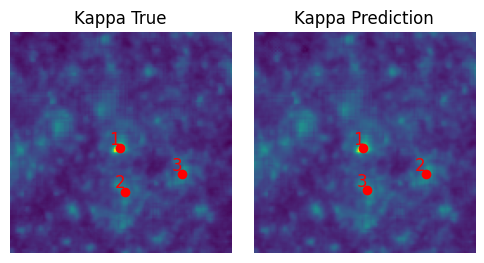

In [36]:
index =  25

prediction = y_pred[index].squeeze()
true_kappa = test_loader.dataset[index][1].numpy().squeeze()

plot_kappa(true_kappa, prediction, show_dpeaks=True)

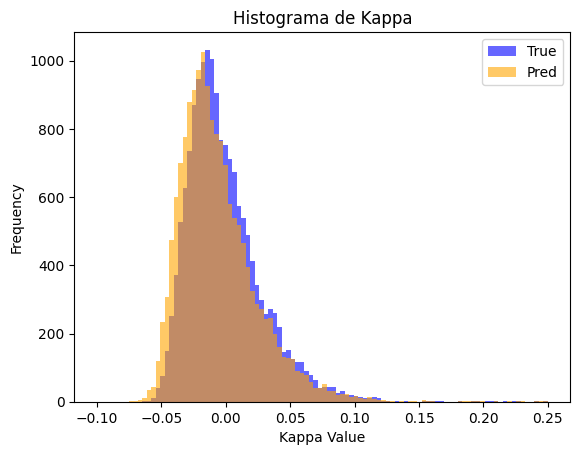

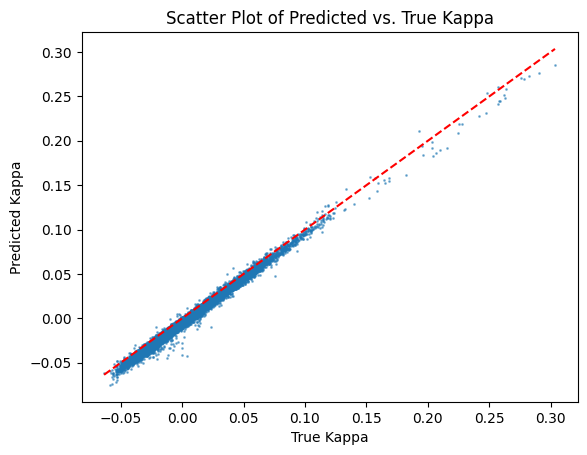

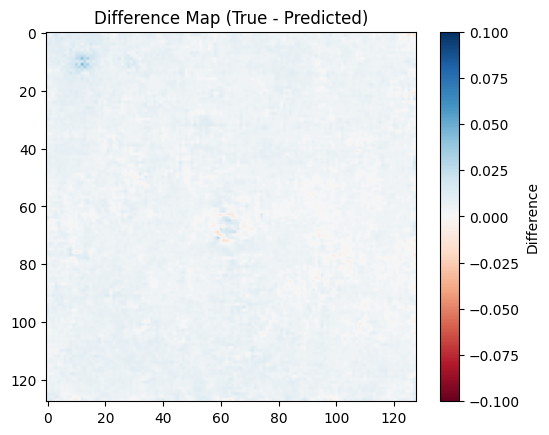

In [37]:
compare_kappa(true_kappa, prediction)

plot_scatter(true_kappa, prediction)

plot_difference_map(true_kappa, prediction)

metrics= ["lr", "dicee", "wmape", "dpeaks"]
history= checkpoint['history']
for met in metrics:
    plot_metric(met, history)

# Submission

## Setup

In [ ]:
TEST_DATASET_PATH = os.path.join('public_test', 'EPSILON')
PREDICTIONS_PATH = os.path.join('losfiducials')
TEST_MODEL_PATH = 'ResUnet_medium_dataset_0.001lr_model_50E.pth' # CHANGE!!
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# https://drive.google.com/file/d/1UO_4QvJdUxcATFYjdSGtEmcMo1QCBdVx/view?usp=sharing
# test https://drive.google.com/file/d/1MtDSfDjhKnr5nYkSdmsPdlB3bXMVspfg/view?usp=sharing

data_zip = 'public_test.tar.gz'

if Path(data_zip).is_file():
    print("File already exists.")
else:
    import gdown

    file_id = '1UO_4QvJdUxcATFYjdSGtEmcMo1QCBdVx'
    url = f'https://drive.google.com/uc?id={file_id}'

    gdown.download(url, data_zip, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1UO_4QvJdUxcATFYjdSGtEmcMo1QCBdVx
From (redirected): https://drive.google.com/uc?id=1UO_4QvJdUxcATFYjdSGtEmcMo1QCBdVx&confirm=t&uuid=0e34445d-4f76-4d7b-b769-7d8812c83e4f
To: /content/public_test.tar.gz
100%|██████████| 5.92G/5.92G [01:38<00:00, 60.0MB/s]


In [ ]:
!mkdir public_test
!tar -xf public_test.tar.gz -C public_test

## Model

In [ ]:
class ToTensor(object):
    def __init__(self):
        pass

    def __call__(self, x):
        return torch.from_numpy(x).float()

transform = v2.Compose([
    ToTensor()
])

In [ ]:
file_id = '1VyZHJ7hJ2t8syZOpOJmjpqP9IZ-bjFDi' #MODEL DRIVE ID CHANGE ACCORDINGLY IF NEEDED

url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1VyZHJ7hJ2t8syZOpOJmjpqP9IZ-bjFDi
From (redirected): https://drive.google.com/uc?id=1VyZHJ7hJ2t8syZOpOJmjpqP9IZ-bjFDi&confirm=t&uuid=a69531a4-6536-49b7-b4a8-851637b34d39
To: /content/ResUnetV3-3Conv-3Skip_model_50E.pth
100%|██████████| 179M/179M [00:09<00:00, 19.7MB/s]


'ResUnetV3-3Conv-3Skip_model_50E.pth'

In [ ]:
model_test = ResUnet(in_channels=3, features=[32, 64, 128, 256, 512]).to(DEVICE)

checkpoint = torch.load(TEST_MODEL_PATH, weights_only=False, map_location=DEVICE)
model_test.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Predict

In [ ]:
def predict_step(model, epsilon, device):
    model.eval()
    with torch.inference_mode():
        epsilon = epsilon.to(device)
        y_hat = model(epsilon)
        y_hat_detached = y_hat.detach()
    return y_hat_detached

In [ ]:
if not os.path.exists(PREDICTIONS_PATH):
    os.makedirs(PREDICTIONS_PATH)

In [ ]:
epsilon_files = os.listdir(TEST_DATASET_PATH)

p_bar = tqdm(epsilon_files, total=len(epsilon_files), desc='')

for epsilon_filepath in p_bar:
    epsilon_data = np.load(os.path.join(TEST_DATASET_PATH, epsilon_filepath))
    epsilon_data_torch = transform(epsilon_data).unsqueeze(0)
    y_hat = predict_step(model_test, epsilon_data_torch, DEVICE)

    y_hat = y_hat.squeeze().cpu().numpy().astype(np.float16)
    np.save(os.path.join(PREDICTIONS_PATH, epsilon_filepath), y_hat)

100%|██████████| 76522/76522 [09:53<00:00, 128.90it/s]


## Plot Predictions

In [ ]:
def plot_prediction(prediction_filepath):
    prediction_image = np.load(prediction_filepath)

    plt.imshow(prediction_image)
    plt.axis('off')
    plt.title('Prediction')
    plt.show()

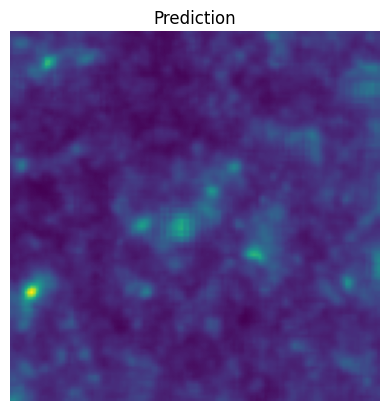

In [ ]:
prediction_filenames = os.listdir(PREDICTIONS_PATH)
prediction_idx = 55

prediction_filepath = os.path.join(PREDICTIONS_PATH, prediction_filenames[prediction_idx])
plot_prediction(prediction_filepath)

## Compress Predictions

In [ ]:
!7z a losfiducials_submission.zip losfiducials


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive:
  0M Scan           1413M 45056 Scan  losfiducials/                               1 folder, 76522 files, 2517267712 bytes (2401 MiB)

Creating archive: losfiducials_submission.zip

Items to compress: 76523

  0%      0% 138 + losfiducials/00923_00138.npy                                         0% 267 + losfiducials/00923_00268.npy                                         0% 418 + losfiducials/00923_00418.npy                                         0% 564 

## Upload to Drive if working in colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

COLAB_PATH = '/content/drive/MyDrive/'
LOCAL_PATH = 'losfiducials_submission.zip'

shutil.copyfile(LOCAL_PATH, os.path.join(COLAB_PATH, LOCAL_PATH))

Mounted at /content/drive


'/content/drive/MyDrive/losfiducials.zip'